In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mathis as mt
import math
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
train = pd.read_csv("datasets/modified_train.csv")
test = pd.read_csv("datasets/modified_test.csv")

train = train.drop(columns = ['Unnamed: 0', 'training'])
test = test.drop(columns = ['Unnamed: 0', 'training'])

house = train.append(test)

# Problem Statement:
We are a Data Scientist working for a company that buys housing with the intent of making cost-effective improvements and flipping them back onto the market. Our goal is to find the most effective features for this process in the context of the Ames, Iowa housing market.

# Analysis

***Lasso to remove less relevant columns***

In [3]:
x_list = house.columns.tolist()
x_list.remove('sale_price')
X = train[x_list]
y = train['sale_price']

In [4]:
sc = StandardScaler()
Z_train = sc.fit_transform(train[x_list])
Z_test = sc.transform(test[x_list])
r_alphas = np.logspace(0,100,1000)


lasso_cv = LassoCV(alphas=r_alphas, random_state=42, cv=5, max_iter = 10000)
lasso_cv.fit(Z_train,y);

In [5]:
coefs = lasso_cv.coef_
lasso_weights = {}
cols = x_list
for i in range(0, len(coefs)):
    lasso_weights[cols[i]] = coefs[i]

- We will use these LASSO coefficients in our analysis to determine which remodeling opportunities are predicted to be significant.

In [6]:
lasso_weights = {key: val for key, val in lasso_weights.items() if val != 0}

***Linear model on remaining columns***

In [7]:
lr = LinearRegression()
lr.fit(train[list(lasso_weights.keys())], train['sale_price']);

- This linear model performs with an RMSE of 28405.96638 when tested (on Kaggle), which is almost as good as the LASSO it is modeled after. Our goal is to use its coefficients for inference.

In [8]:
weights_coefs = pd.DataFrame({'weights': lasso_weights.values(), 'Dollars': lr.coef_}, index = lasso_weights.keys())

***Dataframe containing weights and linear coefficients***

In [9]:
weights_coefs.sort_values(by = 'weights', inplace = True)

In [10]:
max_weight = weights_coefs.iloc[-1]['weights']
weights_coefs['weights'] = weights_coefs['weights'].map(lambda x: abs(x/max_weight))

- Converting assigned LASSO importance values to a percentage.

In [11]:
weights_coefs['importance'] = abs(weights_coefs['weights'] * weights_coefs['Dollars'])

In [12]:
weights_coefs.sort_values(by = 'importance', inplace = True, ascending = False)

- Creating an importance column based on the amount of dollars gained by changing a variable times the LASSO importance percentage.

In [13]:
neighborhoods = [key for key in lasso_weights.keys() if key.split("_")[0] == 'neighborhood']

In [14]:
weights_coefs = weights_coefs.drop(neighborhoods)

- Removing neighborhoods from our selection. Our targets are values that can be changed during remodeling, and neighborhoods cannot be.

In [15]:
pd.DataFrame(weights_coefs['Dollars'][:9]).T

,overall_qual,sale_type_New,bldg_type_TwnhsE,condition_2_PosA,exterior_1st_BrkFace,utilities_NoSeWa,bldg_type_Twnhs,heating_OthW,roof_matl_WdShngl
Dollars,8755.066895,15789.743581,-15277.046132,42448.35048,20096.558592,-57672.945346,-17864.883349,-43863.852252,35796.9645


In [16]:
pd.DataFrame(weights_coefs['Dollars'][9:18]).T

,exter_qual,kitchen_qual,condition_2_PosN,sale_type_Con,kitchen_abv_gr,functional,mas_vnr_type_BrkFace,ms_sub_class_150,overall_cond
Dollars,6698.824165,6588.8478,35067.926568,29189.924238,-12139.47001,6336.268936,-7704.743725,-40675.329513,4729.778943


In [17]:
pd.DataFrame(weights_coefs['Dollars'][18:25]).T

,land_contour_HLS,garage_type_nan,condition_1_PosN,condition_1_Norm,condition_1_PosA,exterior_2nd_CmentBd,bedroom_abv_gr
Dollars,10091.51349,11407.646784,13804.731467,7426.445058,15233.261947,8233.305076,-4447.591327


In [18]:
vis = pd.DataFrame(weights_coefs['Dollars'])
vis['Dollars'] = vis['Dollars'].map(abs)

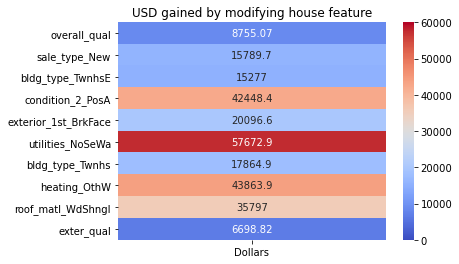

In [19]:
a = sns.heatmap(vis[:10], cmap = 'coolwarm', vmin = 0, vmax = 60000, annot = True, fmt = 'g')
plt.title('USD gained by modifying house feature')
plt.show()

- Columns that cannot be improved: 
  - ***Sale type***: we cannot change how a house was previously sold.
  - ***Adjacent or near to positive off-site feature***: we cannot built parks near homes.
  - ***Land contour***: changing the contour of the land is not within company scope.

- Columns that are difficult to improve:
   - ***Brick exterior***: prohibitively expensive to convert walls to brick. \$20096.56 c.p. 
   - ***Adding water utilities***: expensive and requires contacting public utilities, but possible. \$57672.95 c.p.
   - ***Purchasing an entire Planned Unit Development and coverting to condominium***: significant red tape. \$40675.33 per housing unit converted c.p.

- Columns that can be improved:
   - ***Increase overall quality***: Increases with other improvements on this list. \$8755.07 per level ceteris paribus (c.p.)
   - ***Increase overall condition***: \$4729.78 per level c.p. -\\$4000 for house painting.
   - ***Convert from Townhouse end unit***: Recommended in cases with low red tape. \$15277.05 c.p.
   - ***Convert from Townhouse***: Recommended in cases with low red tape. \$17864.88 c.p.
   - ***Adding gas heating***: as long as there are nearby lines, effective cost efficiency. \$43863.85 c.p. Roughly -\\$6000 for a heater.
   - ***Changing roof tiles to wood shingles***: should recoup cost. \$35796.97 c.p. Up to -\\$8500 for installation.
   - ***Quality of exterior materials***: likely involves expensive restructuring. \$6698.82 per level increase c.p.
   - ***Kitchen quality***: depending on cost of remodeling, may be effective. \$6588.85 per level c.p. -\\$2500 for a stove improvement.
   - ***Kitchens above grade (ground)***: removing extraneous kitchens is a cost-effective method of value gain. $12139.47 c.p., labor cost varies significantly but stays below expected gains.
   - ***Remove brick veneer***: with cost of house painting services, may gain value. \$7704.74
   - ***Remove garage***: not cost effective. \$11407.65 gain c.p., labor cost of -\\$14000
   - ***Cement board exterior***: does not require structural work. \$8233.31 c.p. -\\$6500 for installation.

In [20]:
cost_profit = pd.DataFrame(weights_coefs['Dollars'][:25])
cost_profit['Dollars'] = cost_profit['Dollars'].map(abs)

In [21]:
indices = ['bldg_type_TwnhsE', 'bldg_type_Twnhs', 'heating_OthW', 'roof_matl_WdShngl', 'kitchen_qual', 'kitchen_abv_gr', 'overall_cond', 'garage_type_nan', 'exterior_2nd_CmentBd']
cost_profit = cost_profit.to_dict()

In [22]:
cost_profit = {'Dollars': {col: val for col, val in cost_profit['Dollars'].items() if col in indices}}

In [25]:
costs = [0, 0, 6000, 8500, 2500, 8000, 4000, 14000, 6500]
costs_dict = {}
for i in range(0, len(indices)):
    costs_dict[indices[i]] = costs[i]

In [27]:
cost_profit['Costs'] = costs_dict

In [32]:
cost_profit = pd.DataFrame(cost_profit)
cost_profit['Costs'] = cost_profit['Costs'].map(lambda x: -1*x)

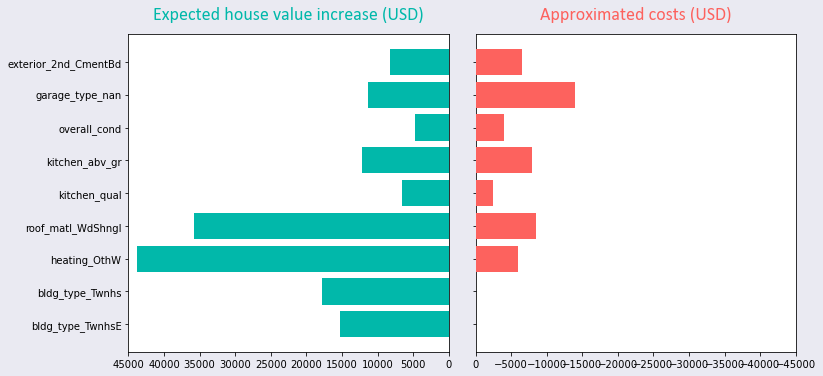

In [51]:
#credit to: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = cost_profit.index
column0 = cost_profit['Dollars']
column1 = cost_profit['Costs']
title0 = 'Expected house value increase (USD)'
title1 = 'Approximated costs (USD)'
fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()
axes[0].barh(index, column0, align='center', color=color_blue, zorder=10)
axes[0].set_xlim([45000, 0])
axes[0].set_title(title0, fontsize=18, pad=15, color=color_blue, **hfont)
axes[1].barh(index, column1, align='center', color=color_red, zorder=10)
axes[1].set_xlim([0, -45000])
axes[1].set_title(title1, fontsize=18, pad=15, color=color_red, **hfont)
plt.show()

- This chart represents the most viable selected features, in order from least to most model importance (top to bottom) with their associated predicted gains and approximate costs.

In [48]:
weights_coefs.loc['year_remod/add']

weights        0.050403
Dollars       49.890287
importance     2.514597
Name: year_remod/add, dtype: float64

- A factor that would be relevant in all remodeling, the year a remodel occurred is not predicted by the model to be significant or cost-effective.

In [49]:
mt.colinearity_pairs(train, weights_coefs[:25].index.tolist())

{'overall_qual': ['exter_qual', 'kitchen_qual'],
 'exter_qual': ['overall_qual', 'kitchen_qual'],
 'kitchen_qual': ['overall_qual', 'exter_qual']}

- Only notable colinearity here is overall quality, which we already understood to be all-encompassing.

In [58]:
{key: val for key, val in mt.colinearity_count(train, weights_coefs.index.tolist()).items() if val > 3}

{'overall_qual': 11,
 'exter_qual': 10,
 'kitchen_qual': 7,
 'garage_cars': 5,
 'bsmt_qual': 8,
 'year_built': 8,
 'foundation_PConc': 7,
 'gr_liv_area': 4,
 'garage_finish': 5,
 'heating_qc': 4,
 'year_remod/add': 7,
 'garage_area': 4}

# Recommendations:

Several features have been identified as having potential for cost-effective remodeling:
 - Adding cement board paneling
 - Converting garages and kitchens to living space
 - Painting the exterior
 - Replacing roof with wooden shingles
 - Purchasing better equipment for kitchens
 - Adding a gas heating system
 - Converting Townhouses to Condominiums
    
Early modeling suggests that these will turn profit for the company, but additional research is required. The accuracy of the model is bounded by its RMSE of 28405.96638, meaning that every feature which showed calculated gain could be entirely nullified by the error, with the exception of adding a gas heater.

Additionally, the model violates line assumptions, having some multicolinearity between variables (though less than expected), and multiple values do not show a strictly linear trend. The model is also built on the principle of all-else-equal, meaning improving more than one housing feature at a time restricts the model's usefulness.

With this in mind, we recommend taking the features identified as suggestions for future research and experimentation for the company as a whole.